## Code to Chapter 2 of LangChain for Life Science and Healthcare book, by Dr. Ivan Reznikov

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1hxKOw6xrZ8AbmQuOQ7xw_j3fsQQe2HDi?usp=sharing)

This notebook demonstrates different embedding models and tokenization approaches for:
1. Medical/biomedical text processing
2. Chemical structure representation (SMILES/SELFIES)
3. Comparative analysis of embedding quality across domains

❗IMPORTANT: if you get an error don't panic - simply restart the notebook and run all cells. This issue is well known for google colab❗

Just click on Runtime -> Restart session and run all


### Installation and Setup

Installing required packages for:
- LangChain ecosystem for LLM orchestration
- Sentence transformers for embedding models
- Chemical informatics tools (DeepChem, SELFIES)
- NLP preprocessing tools

In [ ]:
# Core LangChain packages for LLM orchestration and embeddings
#!pip install -qU langchain langchain-community langchain-core langchain-openai openai langchain_experimental sentence_transformers

!pip install -qU google-ai-generativelanguage==0.6.15 \
      google-cloud-language==2.17.1 \
      langchain \
      langchain-community \
      langchain_huggingface \
      langchain-core \
      langchain-openai \
      langchain-experimental \
      langchain-text-splitters==0.3.8 \
      langcodes==3.5.0 \
      langsmith==0.3.44 \
      language_data==1.3.0 \
      libclang==18.1.1 \
      openai==1.84.0 \
      sentence-transformers==4.1.0 \
      transformers==4.52.4

# Text processing and tokenization utilities
!pip install -q tiktoken spacy #tiktoken==0.6.0
!pip install -q numpy==1.26.4

# Chemical informatics and molecular representation tools
!pip install -q --pre deepchem[tensorflow]

# SELFIES (Self-Referencing Embedded Strings) for molecular representation
!pip install -q selfies

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 30.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
deepchem 2.8.1.dev20250609174000 requires numpy<2, but you have numpy 2.3.0 which is incompatible.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
# Check installed versions of key packages for reproducibility
!pip freeze | grep "lang\|openai\|transformers\|numpy"

google-ai-generativelanguage==0.6.15
google-cloud-language==2.17.1
langchain==0.3.25
langchain-community==0.3.24
langchain-core==0.3.63
langchain-experimental==0.3.4
langchain-huggingface==0.2.0
langchain-openai==0.3.19
langchain-text-splitters==0.3.8
langcodes==3.5.0
langsmith==0.3.44
language_data==1.3.0
libclang==18.1.1
numpy==1.26.4
openai==1.84.0
sentence-transformers==4.1.0
transformers==4.52.4


### API Configuration

Setting up API keys for external services:
- OpenAI API for embeddings and language models
- Hugging Face token for accessing gated models

In [ ]:
import os
from google.colab import userdata

# Configure API keys from Colab secrets
# These keys enable access to OpenAI embeddings and Hugging Face models
try:
    os.environ["OPENAI_API_KEY"] = userdata.get("LC4LS_OPENAI_API_KEY")
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
except Exception as e:
    print(e)

### Import Required Libraries

Importing embedding models from different sources:
- LangChain wrappers for Hugging Face and OpenAI embeddings
- Direct sentence-transformers for more control over model behavior

❗IMPORTANT: if you get an error below - simply restart the notebook and run all cells. This issue is well known for google colab❗

Just click on Runtime -> Restart session and run all

In [ ]:
# LangChain embedding wrappers
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings

# Direct sentence-transformers interface for more granular control
from sentence_transformers import SentenceTransformer

### Utility Functions for Embedding Analysis

These functions help us:
1. Calculate cosine similarity matrices between embeddings
2. Generate embeddings using different model interfaces
3. Compare embedding quality across different models

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import torch

# Sample sentences for testing medical/biomedical text embeddings
# These sentences contain related medical concepts to test semantic understanding
sentences = [
    "The acute inflammation could cause large damage",
    "Chronic inflammation can be harmful to tissues",
    "His condition improved when the local inflammatory reaction subsided",
    "Her joint swelling reduced significantly",
    "The doctor noted no signs of edema in the affected area",
    "The anti-inflammatory medication was found in his blood",
    "A standard procedure that fires up his blood",
]


def compute_similarity_matrix(embeddings_list):
    """Computes the cosine similarity matrix from a list of embeddings.

    Args:
        embeddings_list: List of embeddings or torch.Tensor containing embeddings

    Returns:
        numpy.ndarray: Symmetric similarity matrix with values between -1 and 1
    """
    num_sentences = len(embeddings_list)
    similarity_matrix = np.zeros((num_sentences, num_sentences))

    for i in range(num_sentences):
        for j in range(
            i, num_sentences
        ):  # Only compute upper triangular part for efficiency
            # Handle PyTorch tensors by converting to numpy
            if isinstance(embeddings_list, torch.Tensor):
                _embeddings_list = embeddings_list.detach().numpy()
                embedding_i, embedding_j = [list(_embeddings_list[i])], [
                    list(_embeddings_list[j])
                ]
            else:
                embedding_i, embedding_j = [embeddings_list[i]], [embeddings_list[j]]

            # Calculate cosine similarity between two embeddings
            similarity = np.ndarray.flatten(
                cosine_similarity(embedding_i, embedding_j)
            )[0]

            # Fill both triangular parts (matrix is symmetric)
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity

    # Ensure diagonal is 1.0 (self-similarity)
    np.fill_diagonal(similarity_matrix, 1)
    return similarity_matrix


def get_embeddings(model, sentences, use_encode=True):
    """Gets embeddings for sentences using a specified model.

    Args:
        model: Embedding model (either LangChain wrapper or SentenceTransformer)
        sentences: List of strings to embed
        use_encode: Boolean, whether to use .encode() method (SentenceTransformer)
                   or .embed_query() method (LangChain wrapper)

    Returns:
        List or numpy.ndarray of embeddings
    """
    if not use_encode:
        # LangChain interface - embed each sentence individually
        embeddings_list = [model.embed_query(s) for s in sentences]
    else:
        # SentenceTransformer interface - batch embedding (more efficient)
        embeddings_list = model.encode(sentences)
    return embeddings_list

### Initialize Different Embedding Models

We're comparing several types of embedding models:
1. **General-purpose models**: MPNet (good general performance)
2. **Commercial models**: OpenAI's text-embedding-3-large (high quality, API-based)
3. **Multilingual models**: BGE-M3 (supports multiple languages)
4. **Domain-specific models**: Medical embeddings (MedEmbed, BGE-medical)

This comparison helps understand which models work best for life science applications.

In [ ]:
# Initialize different embedding models for comparison

# 1. MPNet: Strong general-purpose sentence transformer
# Good baseline for semantic similarity tasks
mpnet_embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2"
)

# 2. OpenAI: Commercial embedding model with high performance
# Large model (3072 dimensions) with strong semantic understanding
openai_embedding = OpenAIEmbeddings(model="text-embedding-3-large")

# 3. BGE-M3: Multilingual embedding model
# Good for cross-lingual applications and general semantic tasks
bge_embedding = SentenceTransformer("BAAI/bge-m3")

# 4. MedEmbed: Specialized medical embedding model
# Trained on medical literature and clinical text
med_model = SentenceTransformer("abhinand/MedEmbed-large-v0.1")

# 5. BGE Medical: BGE model fine-tuned on medical data
# Combines BGE's strong base with medical domain knowledge
bge_med_model = SentenceTransformer("ls-da3m0ns/bge_large_medical")

# Note: Scientific paper embedding model commented out due to potential loading issues
# sci_model = SentenceTransformer('fine-tuned/jinaai_jina-embeddings-v2-base-en-scientific-papers-from-arxiv', trust_remote_code=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/123 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/15.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/687 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/444 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/384k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.57k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/742 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

### Generate Embeddings and Similarity Matrices

For each model, we:
1. Generate embeddings for our test sentences
2. Compute pairwise cosine similarity matrices
3. Store results for visualization and analysis

The similarity matrices help us understand how well each model captures semantic relationships in medical text.

In [ ]:
# Generate embeddings and similarity matrices for all models
# This allows us to compare how different models understand medical terminology

# MPNet embeddings (using LangChain wrapper)
mpnet_embeddings_list = get_embeddings(mpnet_embeddings, sentences, use_encode=False)
mpnet_matrix = compute_similarity_matrix(mpnet_embeddings_list)

# OpenAI embeddings (using LangChain wrapper)
openai_embeddings_list = get_embeddings(openai_embedding, sentences, use_encode=False)
openai_matrix = compute_similarity_matrix(openai_embeddings_list)

# BGE-M3 embeddings (using SentenceTransformer directly)
bge_embeddings_list = get_embeddings(bge_embedding, sentences)
# Alternative: bge_matrix = bge_embedding.similarity(bge_embeddings_list, bge_embeddings_list, similarity_fn_name="cosine")
bge_matrix = compute_similarity_matrix(bge_embeddings_list)

# Medical embeddings (specialized for medical text)
med_embeddings_list = get_embeddings(med_model, sentences)
# Alternative: med_matrix = med_model.similarity(med_embeddings_list, med_embeddings_list, similarity_fn_name="cosine")
med_matrix = compute_similarity_matrix(med_embeddings_list)

# BGE Medical embeddings (BGE fine-tuned on medical data)
bge_med_embeddings_list = get_embeddings(bge_med_model, sentences)
# Alternative: bge_med_matrix = bge_med_model.similarity(bge_med_embeddings_list, bge_med_embeddings_list, similarity_fn_name="cosine")
bge_med_matrix = compute_similarity_matrix(bge_med_embeddings_list)

# Scientific embeddings (commented out)
# sci_embeddings_list = get_embeddings(sci_model, sentences)
# sci_matrix = sci_model.similarity(sci_embeddings_list)

### Examining Embedding Structure

Let's look at the actual embedding vectors to understand:
- Dimensionality of different models
- Numerical range and distribution of values
- Overall similarity levels across models

In [ ]:
# Display first 10 dimensions of OpenAI embedding for the first sentence
# This gives us insight into the numerical representation
openai_embeddings_list[0][:10]

[-0.025218956172466278,
 0.010054616257548332,
 0.016303163021802902,
 0.03227666765451431,
 0.04192670062184334,
 0.02273152396082878,
 -0.022611647844314575,
 -0.02013920247554779,
 -0.01266192365437746,
 -0.022551709786057472]

In [ ]:
# Compare embedding dimensions across different models
# Higher dimensions often mean more expressive representations but increased computational cost
len(mpnet_embeddings_list[0]), len(openai_embeddings_list[0]), len(
    bge_embeddings_list[0]
), len(bge_med_embeddings_list[0]), len(
    med_embeddings_list[0]
)  # , len(sci_embeddings_list[0])

(768, 3072, 1024, 1024, 1024)

In [ ]:
# Calculate average similarity scores across all sentence pairs for each model
# Lower averages might indicate more discriminative embeddings
# Higher averages might suggest the model sees more general similarity
np.average(mpnet_matrix), np.average(openai_matrix), np.average(bge_matrix), np.average(
    med_matrix
), np.average(bge_med_matrix)

(0.4844296429200474,
 0.41883934906276327,
 0.5871214659846559,
 0.7608378760668696,
 0.5789409717734979)

### Visualizing Similarity Matrices

Heat maps help us visually compare how different models understand semantic relationships:
- Darker colors indicate higher similarity
- Medical models should show stronger clustering of medical terms
- General models might show more distributed similarities

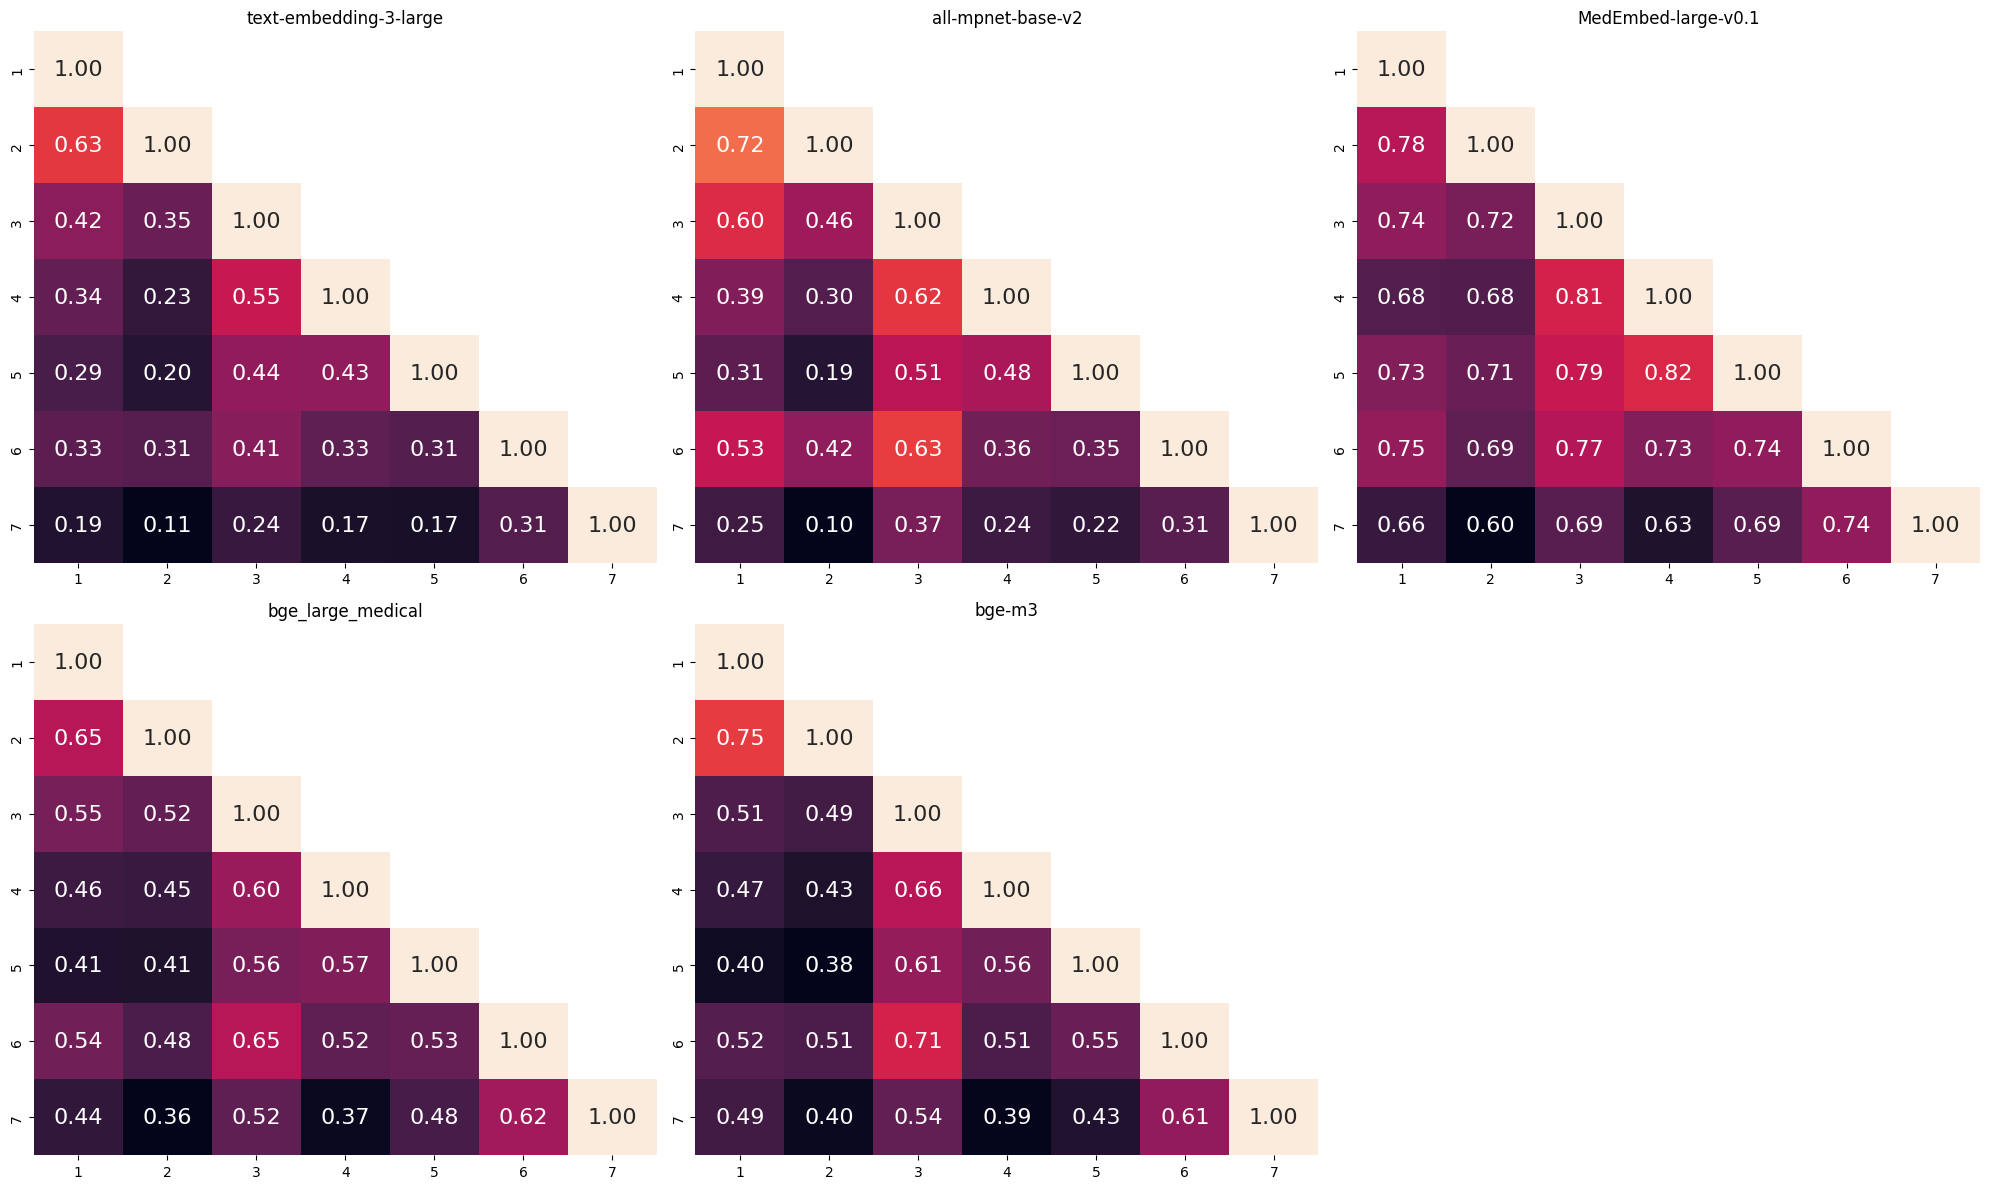

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the matplotlib figure for multiple heatmaps
plt.figure(figsize=(20, 12))

# Create a mask to show only the upper triangular part (avoid redundancy)
# This makes the visualization cleaner since similarity matrices are symmetric
mask = np.triu(np.ones_like(openai_matrix, dtype=bool))
np.fill_diagonal(mask, False)  # Keep diagonal visible (self-similarity = 1.0)

# Define models and their similarity matrices for comparison
heatmaps = [
    (openai_matrix, "text-embedding-3-large"),  # Commercial, high-quality
    (mpnet_matrix, "all-mpnet-base-v2"),  # Strong general-purpose baseline
    (med_matrix, "MedEmbed-large-v0.1"),  # Medical specialist
    (bge_med_matrix, "bge_large_medical"),  # BGE + medical fine-tuning
    (bge_matrix, "bge-m3"),  # Multilingual general-purpose
]

# Create subplot for each model's similarity matrix
for idx, (matrix, title) in enumerate(heatmaps, start=1):
    plt.subplot(2, 3, idx)
    # Create heatmap with annotations showing exact similarity values
    sns.heatmap(
        matrix,
        mask=mask,
        fmt=".2f",
        xticklabels=[x + 1 for x in range(len(sentences))],
        yticklabels=[x + 1 for x in range(len(sentences))],
        annot=True,
        cbar=False,
        annot_kws={"fontsize": 16},
    )
    plt.title(title)

# Display the comprehensive comparison
plt.tight_layout()
plt.show()

In [ ]:
# Display the sentences with their indices for reference
# This helps interpret the similarity matrices above
for idx, s in enumerate(sentences):
    print(f"{idx+1}. {s}")

1. The acute inflammation could cause large damage
2. Chronic inflammation can be harmful to tissues
3. His condition improved when the local inflammatory reaction subsided
4. Her joint swelling reduced significantly
5. The doctor noted no signs of edema in the affected area
6. The anti-inflammatory medication was found in his blood
7. A standard procedure that fires up his blood


### Testing with Ambiguous Language

Now we test the models with sentences that contain ambiguous words (like "fly", "cloud", "scared"):
- This tests how well models handle polysemy (multiple meanings)
- Medical models might struggle more with non-medical contexts
- General models should handle ambiguity better

In [ ]:
# Test sentences with ambiguous terms that have multiple meanings
# This tests the models' ability to understand context and disambiguate word meanings
sentences = [
    "I like flying",  # flying = activity/aviation
    "I have aerophobia",  # clinical term for fear of flying
    "I'm scared to fly",  # emotional state + aviation
    "A fly can scare me",  # fly = insect
    "I fear scary pictures of airplanes in the clouds",  # aviation + cloud = sky
    "I have airplane photos in my cloud",  # cloud = cloud storage
]

In [ ]:
# Re-generate embeddings for the ambiguous sentences using the same models
# This will show how each model handles polysemy and context

mpnet_embeddings_list = get_embeddings(mpnet_embeddings, sentences, use_encode=False)
mpnet_matrix = compute_similarity_matrix(mpnet_embeddings_list)

openai_embeddings_list = get_embeddings(openai_embedding, sentences, use_encode=False)
openai_matrix = compute_similarity_matrix(openai_embeddings_list)

bge_embeddings_list = get_embeddings(bge_embedding, sentences)
bge_matrix = compute_similarity_matrix(bge_embeddings_list)

med_embeddings_list = get_embeddings(med_model, sentences)
med_matrix = compute_similarity_matrix(med_embeddings_list)

bge_med_embeddings_list = get_embeddings(bge_med_model, sentences)
bge_med_matrix = compute_similarity_matrix(bge_med_embeddings_list)

In [ ]:
# Compare average similarities for ambiguous sentences
# Changes from medical sentences might indicate domain specificity
np.average(mpnet_matrix), np.average(openai_matrix), np.average(bge_matrix), np.average(
    med_matrix
), np.average(bge_med_matrix)

(0.5833767322597677,
 0.5584084721719779,
 0.7632300853729248,
 0.7752267585860358,
 0.6996756907966402)

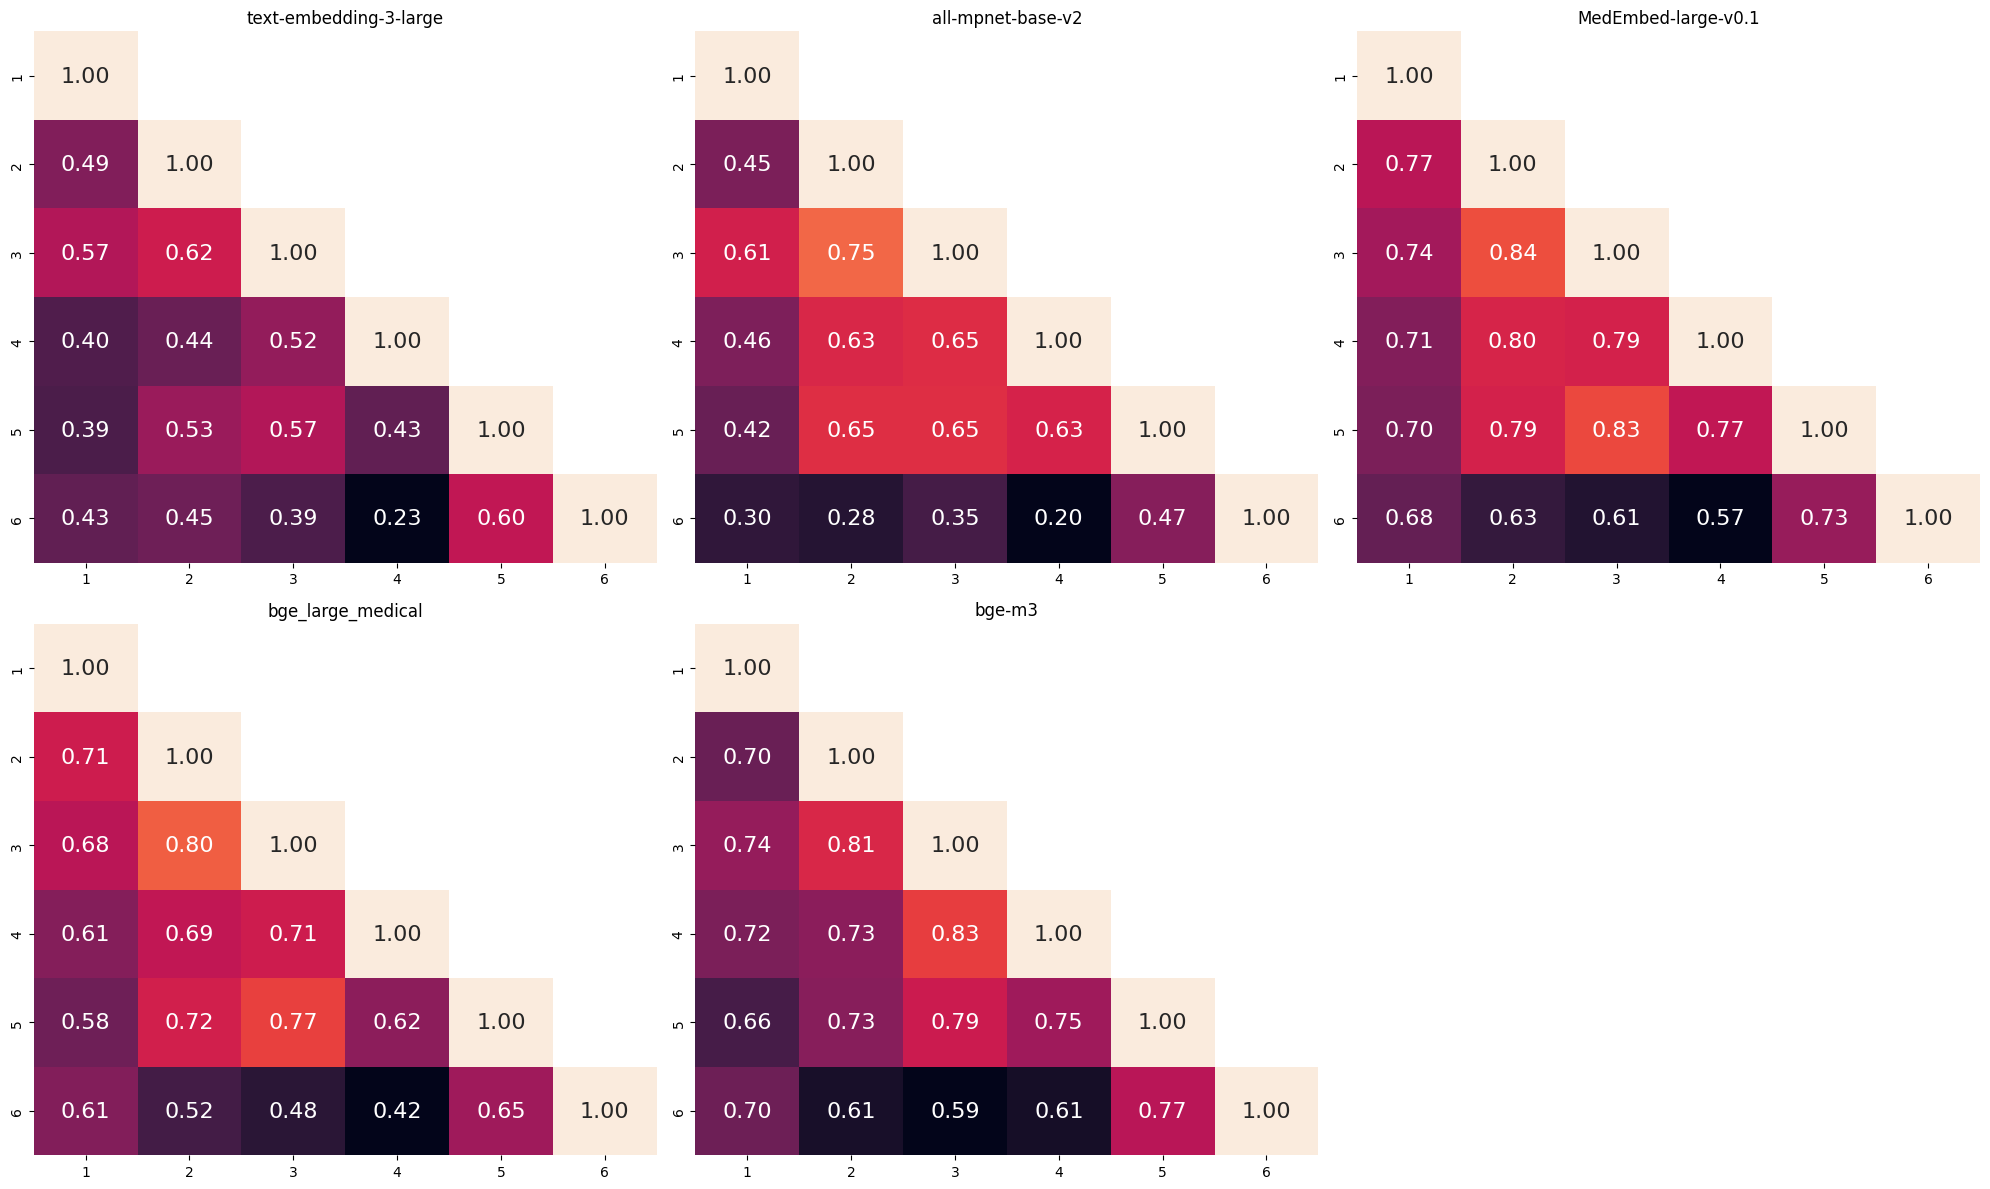

In [ ]:
# Visualize similarity matrices for ambiguous sentences
# Compare with medical sentences to see how domain affects understanding

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 12))

# Create mask for upper triangular visualization
mask = np.triu(np.ones_like(openai_matrix, dtype=bool))
np.fill_diagonal(mask, False)

# Same models, now applied to ambiguous sentences
heatmaps = [
    (openai_matrix, "text-embedding-3-large"),
    (mpnet_matrix, "all-mpnet-base-v2"),
    (med_matrix, "MedEmbed-large-v0.1"),
    (bge_med_matrix, "bge_large_medical"),
    (bge_matrix, "bge-m3"),
]

for idx, (matrix, title) in enumerate(heatmaps, start=1):
    plt.subplot(2, 3, idx)
    sns.heatmap(
        matrix,
        mask=mask,
        fmt=".2f",
        xticklabels=[x + 1 for x in range(len(sentences))],
        yticklabels=[x + 1 for x in range(len(sentences))],
        annot=True,
        cbar=False,
        annot_kws={"fontsize": 16},
    )
    plt.title(title)

plt.tight_layout()
plt.show()

## Chemical Structure Processing

Now we shift focus to chemical informatics:
- **SMILES**: Simplified Molecular Input Line Entry System (text representation of molecules)
- **SELFIES**: Self-Referencing Embedded Strings (more robust molecular representation)
- We'll test different embedding approaches for chemical structures

In [ ]:
import selfies as sf

# Sample SMILES strings representing different chemical compounds
# These include various functional groups and structural features
sentences_smiles = [
    "ClC1CCCCC1",  # Chlorocyclohexane (saturated ring with halogen)
    "ClC1=CC=CC=C1",  # Chlorobenzene (aromatic ring with chlorine)
    "Clc1ccccc1",  # Alternative notation for chlorobenzene
    "BrC1=CC=CC=C1",  # Bromobenzene (similar to chlorobenzene, different halogen)
    "CC1=CC=CC=C1",  # Toluene (methylbenzene)
    "CCCCCCCl",  # 1-Chlorohexane (linear alkyl halide)
]

# Convert SMILES to SELFIES format
# SELFIES are more robust for ML applications (always represent valid molecules)
# Adding spaces between tokens for better tokenization
sentences_selfies = [sf.encoder(x).replace("][", "]  [") for x in sentences_smiles]

In [ ]:
# Display the SELFIES representations
# Notice how they use bracket notation with explicit bonding information
sentences_selfies

['[Cl]  [C]  [C]  [C]  [C]  [C]  [C]  [Ring1]  [=Branch1]',
 '[Cl]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[Cl]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[Br]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[C]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[C]  [C]  [C]  [C]  [C]  [C]  [Cl]']

### Chemical-Specific Embedding Models

Testing specialized models for chemical structures:
1. **ChemBERTa**: BERT fine-tuned on chemical data
2. **RoBERTa-ZINC**: RoBERTa trained on ZINC chemical database
3. **ChemBed**: Specialized for SELFIES representation
4. **OpenAI**: General model applied to chemical strings

In [ ]:
import selfies as sf  # SELFIES library for molecular string representation

# Test dataset: 6 chemical compounds in SMILES notation
# These molecules are chosen to test chemical similarity:
# - ClC1CCCCC1: Chlorocyclohexane (aliphatic ring with Cl)
# - ClC1=CC=CC=C1, Clc1ccccc1: Chlorobenzene (aromatic ring with Cl, different notations)
# - BrC1=CC=CC=C1: Bromobenzene (aromatic ring with Br)
# - CC1=CC=CC=C1: Toluene (aromatic ring with methyl group)
# - CCCCCCCl: 1-Chloroheptane (linear alkyl chain with Cl)
sentences_smiles = [
    "ClC1CCCCC1",  # Chlorocyclohexane
    "ClC1=CC=CC=C1",  # Chlorobenzene (explicit double bonds)
    "Clc1ccccc1",  # Chlorobenzene (implicit aromaticity)
    "BrC1=CC=CC=C1",  # Bromobenzene
    "CC1=CC=CC=C1",  # Toluene
    "CCCCCCCl",  # 1-Chloroheptane
]

# Convert SMILES to SELFIES format
# SELFIES is a more robust molecular representation that guarantees valid molecules
# The replace operation adds spaces between tokens for better tokenization
sentences_selfies = [sf.encoder(x).replace("][", "]  [") for x in sentences_smiles]

In [ ]:
# Display the SELFIES representations
# This helps us understand how different molecular representations look
sentences_selfies

['[Cl]  [C]  [C]  [C]  [C]  [C]  [C]  [Ring1]  [=Branch1]',
 '[Cl]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[Cl]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[Br]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[C]  [C]  [=C]  [C]  [=C]  [C]  [=C]  [Ring1]  [=Branch1]',
 '[C]  [C]  [C]  [C]  [C]  [C]  [Cl]']

### ChemBERTa Embeddings

ChemBERTa is a transformer model specifically trained on chemical data.
This model has been fine-tuned on the ClinTox dataset for toxicity prediction.

In [ ]:
# Load ChemBERTa model fine-tuned on ClinTox dataset
# ClinTox is a dataset for clinical toxicity prediction
# This model should understand chemical toxicity patterns
model = SentenceTransformer("HassanCS/chemBERTa-tuned-on-ClinTox-4")

# Generate embeddings for our SMILES molecules
# get_embeddings() function converts molecules to dense vector representations
chemberta_embeddings = get_embeddings(model, sentences_smiles)

# Compute pairwise similarity matrix
# This matrix shows how similar each molecule is to every other molecule
# Higher values indicate greater chemical similarity
chemberta_matrix = compute_similarity_matrix(chemberta_embeddings)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/205 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/20.2k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/733 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/13.7M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.64k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/6.96k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/14.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.0k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/965 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

### OpenAI Embeddings on SMILES

Testing general-purpose OpenAI embeddings on chemical data.
These embeddings weren't specifically trained on chemistry, so performance may vary.

In [ ]:
# Generate OpenAI embeddings for SMILES strings
# OpenAI embeddings are general-purpose and not chemistry-specific
# use_encode=False indicates we're using OpenAI's API rather than a local encoder
openai_embeddings_list = get_embeddings(
    openai_embedding, sentences_smiles, use_encode=False
)

# Compute similarity matrix for OpenAI embeddings
# This will show how well general NLP embeddings capture chemical similarity
openai_smiles_matrix = compute_similarity_matrix(openai_embeddings_list)

### RoBERTa-ZINC Embeddings

RoBERTa model trained on the ZINC database (480M parameters).
ZINC is a large database of commercially available compounds.

In [ ]:
from transformers import (
    RobertaTokenizerFast,
    RobertaForMaskedLM,
    DataCollatorWithPadding,
)

# Load RoBERTa model trained on ZINC database
# ZINC contains millions of purchasable compounds for virtual screening
tokenizer = RobertaTokenizerFast.from_pretrained(
    "entropy/roberta_zinc_480m", max_len=128
)
model = RobertaForMaskedLM.from_pretrained("entropy/roberta_zinc_480m")

# Data collator handles batching and padding of tokenized inputs
collator = DataCollatorWithPadding(tokenizer, padding=True, return_tensors="pt")

# Tokenize SMILES strings and prepare for model input
inputs = collator(tokenizer(sentences_smiles))

# Get model outputs with hidden states
# output_hidden_states=True returns intermediate layer representations
outputs = model(**inputs, output_hidden_states=True)

# Extract embeddings from the last hidden layer
full_embeddings = outputs[1][-1]  # Last layer hidden states
mask = inputs["attention_mask"]  # Attention mask for padding tokens

# Compute mean pooling over sequence length (ignoring padding)
# This creates a single vector representation for each molecule
roberta_zinc_embeddings = (full_embeddings * mask.unsqueeze(-1)).sum(1) / mask.sum(
    -1
).unsqueeze(-1)

# Normalize embeddings to unit length (L2 normalization)
# This ensures similarity is based on direction, not magnitude
roberta_zinc_embeddings /= roberta_zinc_embeddings.norm(dim=-1, p=2).unsqueeze(-1)

# Compute similarity matrix
roberta_zinc_matrix = compute_similarity_matrix(roberta_zinc_embeddings)

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/40.5k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/24.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/110k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/958 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/409M [00:00<?, ?B/s]

### ChemBed-ChemSELFIES Embeddings

This model is specifically designed for SELFIES representations.
It should better understand the SELFIES tokenization scheme.

In [ ]:
# Load ChemBed model trained on SELFIES representations
# This model understands the specific tokenization of SELFIES format
model = SentenceTransformer("gbyuvd/chembed-chemselfies-bed")

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/201 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/34.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/44.5M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/24.0k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/72.5k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [ ]:
# Generate embeddings using SELFIES representations
# This should capture molecular similarity better than SMILES for this model
chem_embeddings = get_embeddings(model, sentences_selfies)
print(f"Embedding shape: {chem_embeddings.shape}")  # Shows dimensionality of embeddings

Embedding shape: (6, 320)


In [ ]:
# Compute similarity matrix for ChemBed embeddings
# This will show how SELFIES-trained models perform on similarity tasks
chem_matrix = compute_similarity_matrix(chem_embeddings)

### OpenAI Embeddings on SELFIES

Testing how general-purpose embeddings perform on SELFIES format.
This comparison helps understand format-specific vs. general embedding performance.

In [ ]:
# Generate OpenAI embeddings for SELFIES strings
# Comparing general embeddings on SELFIES vs SMILES format
openai_embeddings_list = get_embeddings(
    openai_embedding, sentences_selfies, use_encode=False
)

# Compute similarity matrix for OpenAI-SELFIES combination
openai_selfies_matrix = compute_similarity_matrix(openai_embeddings_list)

### Similarity Analysis

Compare average similarities across different embedding methods.
This helps identify which methods produce more discriminative representations.

In [ ]:
# Calculate average similarity scores for each embedding method
# Lower averages might indicate better discrimination between molecules
# Higher averages might indicate the method finds everything similar
print("Average similarity scores:")
print(f"ChemBERTa: {np.average(chemberta_matrix):.3f}")
print(f"OpenAI-SMILES: {np.average(openai_smiles_matrix):.3f}")
print(f"RoBERTa-ZINC: {np.average(roberta_zinc_matrix):.3f}")
print(f"ChemBed-SELFIES: {np.average(chem_matrix):.3f}")
print(f"OpenAI-SELFIES: {np.average(openai_selfies_matrix):.3f}")

np.average(chemberta_matrix), np.average(openai_smiles_matrix), np.average(
    roberta_zinc_matrix
), np.average(chem_matrix), np.average(openai_selfies_matrix)

Average similarity scores:
ChemBERTa: 0.983
OpenAI-SMILES: 0.762
RoBERTa-ZINC: 0.795
ChemBed-SELFIES: 0.628
OpenAI-SELFIES: 0.870


(0.9827958047389984,
 0.7623203565160098,
 0.7954584293895297,
 0.6279686755604215,
 0.8698231120335819)

### Visualization of Similarity Matrices

Create heatmaps to visualize how different embedding methods capture molecular similarity.
Each heatmap shows pairwise similarities between our 6 test molecules.

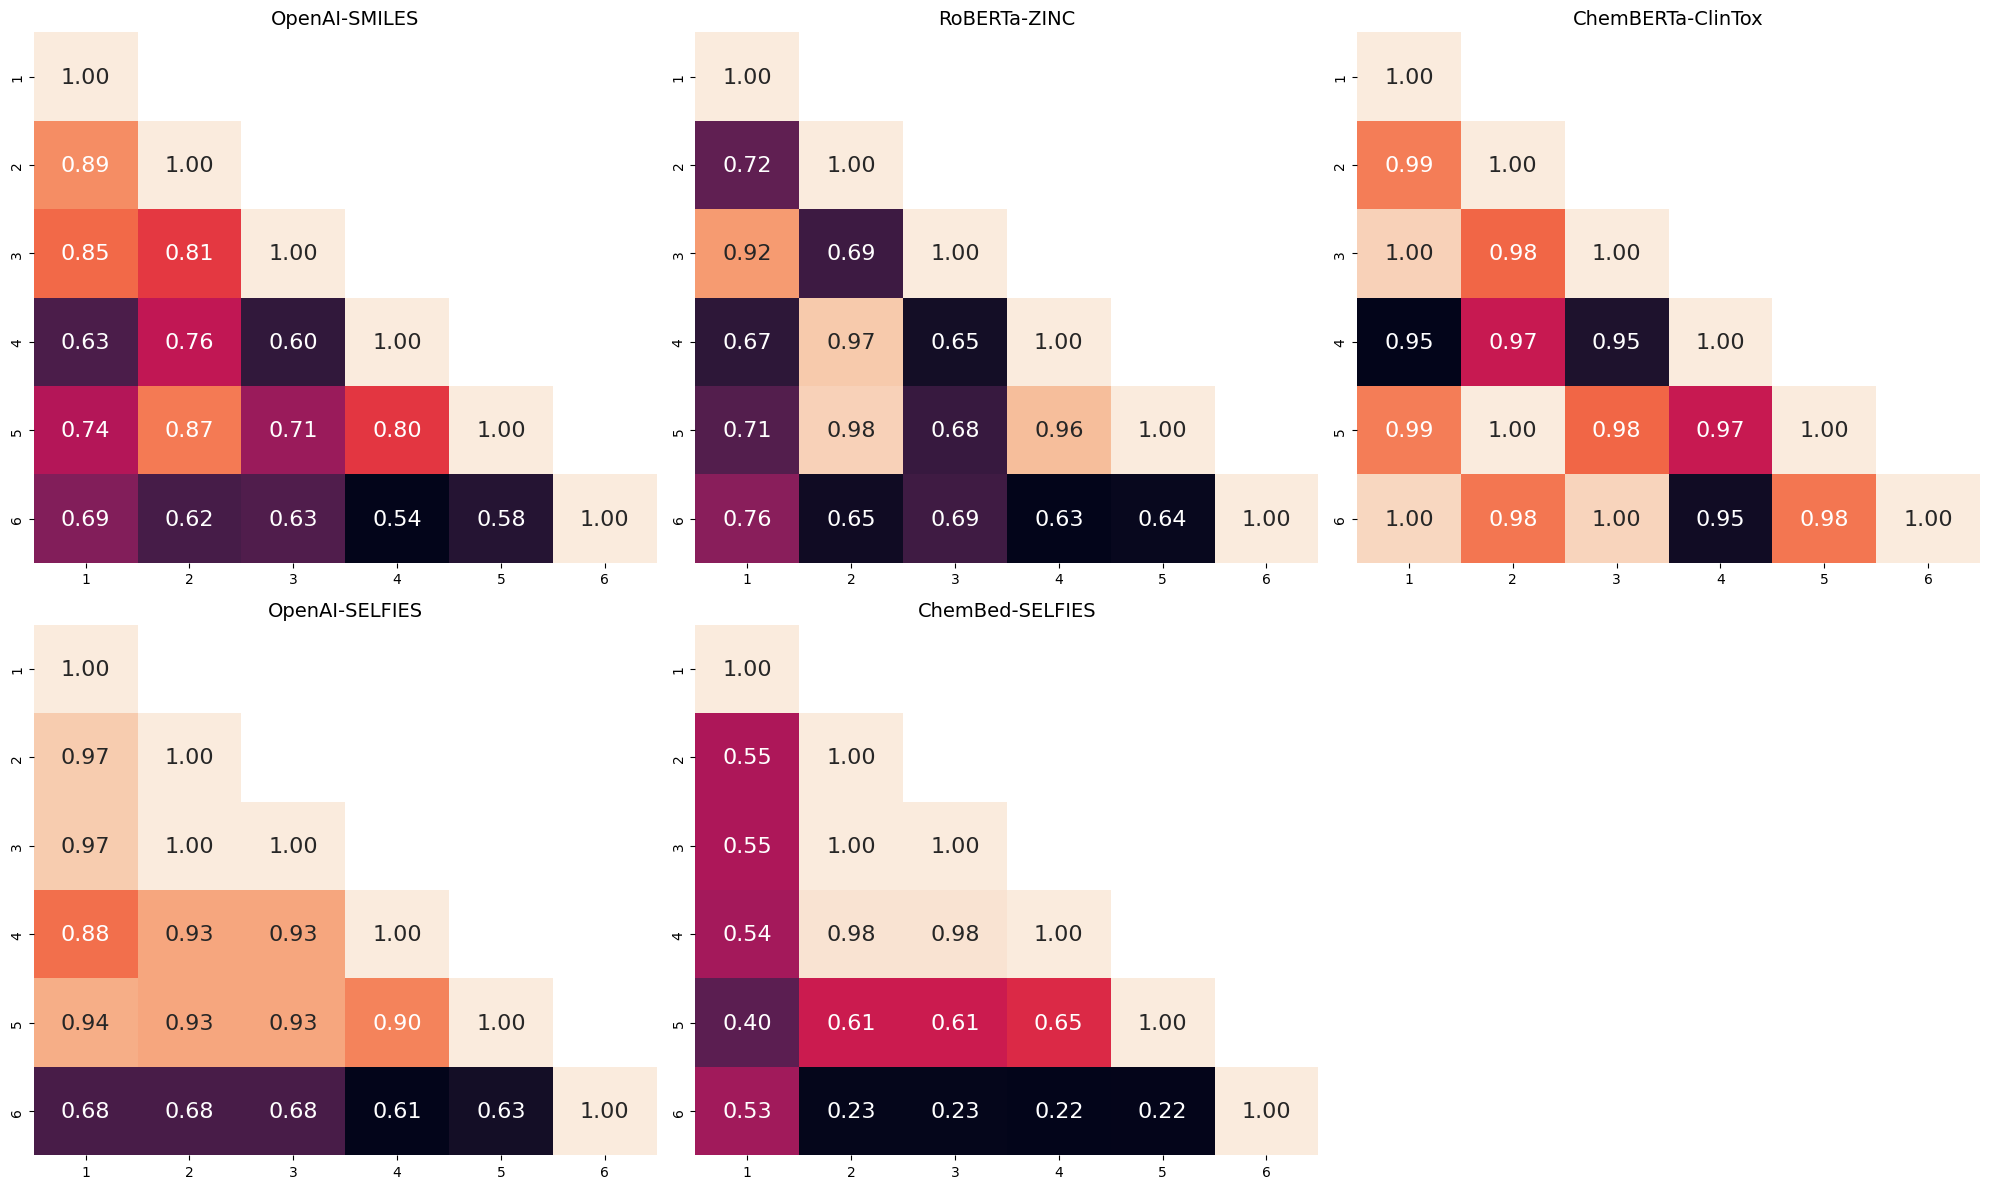

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the matplotlib figure for multiple subplots
plt.figure(figsize=(20, 12))  # Large figure to accommodate 5 heatmaps

# Create upper triangular mask to avoid redundant information
# Since similarity matrices are symmetric, we only need to show one triangle
mask = np.triu(np.ones_like(openai_smiles_matrix, dtype=bool))
np.fill_diagonal(mask, False)  # Keep diagonal (self-similarity)

# Define all embedding methods and their matrices for visualization
heatmaps = [
    (openai_smiles_matrix, "OpenAI-SMILES"),
    (roberta_zinc_matrix, "RoBERTa-ZINC"),
    (chemberta_matrix, "ChemBERTa-ClinTox"),
    (openai_selfies_matrix, "OpenAI-SELFIES"),
    (chem_matrix, "ChemBed-SELFIES"),
]

# Create individual heatmaps for each embedding method
for idx, (matrix, title) in enumerate(heatmaps, start=1):
    plt.subplot(2, 3, idx)  # 2x3 grid layout

    # Create heatmap with annotations showing similarity values
    sns.heatmap(
        matrix,
        mask=mask,  # Hide upper triangle
        fmt=".2f",  # Format numbers to 2 decimal places
        xticklabels=[
            x + 1 for x in range(len(sentences_selfies))
        ],  # Label molecules 1-6
        yticklabels=[
            x + 1 for x in range(len(sentences_selfies))
        ],  # Label molecules 1-6
        annot=True,  # Show similarity values in cells
        cbar=False,  # No color bar for cleaner look
        annot_kws={"fontsize": 16},  # Large font for readability
    )
    plt.title(title, fontsize=14)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Expected patterns to look for:
# - Molecules 2 & 3 (both chlorobenzene) should have high similarity
# - Molecules 2,3,4 (aromatic halides) should cluster together
# - Molecule 5 (toluene) should be similar to other aromatics but distinct
# - Molecules 1 & 6 (aliphatic chlorides) might show some similarity

---
## Tokenization Comparison Study

This section evaluates different tokenization strategies for molecular data.
Proper tokenization is crucial for training effective molecular language models.

In [ ]:
# Extended test dataset with more complex molecular structures
# This dataset tests tokenizer robustness on various chemical features:
smiles = [
    "ClCCCN1CCCC1",  # Chloroalkyl pyrrolidine (heteroatom, ring)
    "CI.Oc1ncccc1Br",  # Salt notation with pyridine derivative
    "COC(=O)Cc1c(C)nn(Cc2ccc(C=O)cc2)c1C.[Mg+]Cc1ccccc1",  # Complex organometallic
    "N#Cc1ccnc(CO)c1",  # Nitrile group with pyridine
    "C=C(O)C(=O)N [O-]C(=O)C1=CC=CC=C1",  # Charged species with double bonds
    "C1CC[13CH2]CC1C1CCCCC1",  # Isotope labeling (carbon-13)
    "C1=CC2=C(C(=C1)[O-])NC(=CC2=O)C(=O)O",  # Charged aromatic system
    "C([13C]N(CC(=O)[O-])CC(=O)[O-])N(CC#N)CC(=O)[O-].[Na+].[Na+].[Na+]",  # Multiple charges and isotopes
]

# Dictionary to store tokenization results from different methods
results_dict = {}


def run_tokenizer(func):
    """Apply tokenizer function to all SMILES strings"""
    return [func(smi) for smi in smiles]


def run_decoding(tokenizer, encoded):
    """Decode tokenized results back to readable format"""
    return [[tokenizer.decode(y) for y in x["input_ids"]] for x in encoded]


def save_results(token_list, method_name):
    """Store tokenization results with method name as key"""
    results_dict[method_name] = token_list

### SpaCy Tokenizer

SpaCy's English tokenizer - not designed for chemistry but serves as baseline.
This will likely produce poor results for chemical notation.

In [ ]:
from spacy.lang.en import English

# Initialize SpaCy English tokenizer
# This is a general NLP tokenizer, not designed for chemical structures
# Expected to perform poorly on SMILES due to chemical-specific notation
nlp = English()

# Apply SpaCy tokenization to our molecular dataset
res = run_tokenizer(nlp.tokenizer)
save_results(res, "spacy")

# Display tokenization of first molecule
print("SpaCy tokenization of first molecule:")
print(f"Original: {smiles[0]}")
print(f"Tokens: {res[0]}")
res[0]

SpaCy tokenization of first molecule:
Original: ClCCCN1CCCC1
Tokens: ClCCCN1CCCC1


ClCCCN1CCCC1

### BLOOM-560M Tokenizer

BigScience BLOOM model tokenizer - another general-purpose approach.
This multilingual model wasn't trained on chemical data.

In [ ]:
from transformers import AutoTokenizer

# Load BLOOM-560M tokenizer (BigScience multilingual model)
# BLOOM is a large language model trained on diverse text but not chemistry-specific
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-560m")

# Tokenize molecules and decode to see token boundaries
encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "bloom560m")

print("BLOOM-560M tokenization of first molecule:")
print(f"Original: {smiles[0]}")
print(f"Tokens: {res[0]}")
res[0]

tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

BLOOM-560M tokenization of first molecule:
Original: ClCCCN1CCCC1
Tokens: ['Cl', 'CC', 'CN', '1', 'CCCC', '1']


['Cl', 'CC', 'CN', '1', 'CCCC', '1']

### Mistral-7B Tokenizer

Mistral's tokenizer - represents modern LLM tokenization approaches.
Again, not chemistry-specific but may handle symbolic notation better.

In [ ]:
# Load Mistral-7B tokenizer
# Mistral is a modern, efficient language model with SentencePiece tokenization
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")

encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "mistral7")

print("Mistral-7B tokenization of first molecule:")
print(f"Original: {smiles[0]}")
print(f"Tokens: {res[0]}")
res[0]

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Mistral-7B tokenization of first molecule:
Original: ClCCCN1CCCC1
Tokens: ['<s>', 'Cl', 'CC', 'CN', '1', 'CC', 'CC', '1']


['<s>', 'Cl', 'CC', 'CN', '1', 'CC', 'CC', '1']

### Falcon Tokenizers

Technology Innovation Institute's Falcon model tokenizer.
Another general-purpose approach for comparison.

In [ ]:
# Load Falcon-7B tokenizer
# Falcon models are efficient architectures from Technology Innovation Institute
tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-7B")

encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "falcon7")

print("Falcon-7B tokenization of first molecule:")
print(f"Original: {smiles[0]}")
print(f"Tokens: {res[0]}")
res[0]

tokenizer_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

Falcon-7B tokenization of first molecule:
Original: ClCCCN1CCCC1
Tokens: ['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1']


['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1']

Larger Falcon model - may require special access permissions.
Tests if larger models have better chemical tokenization.

In [ ]:
# Load Falcon-180B tokenizer
# Falcon models are efficient architectures from Technology Innovation Institute
tokenizer = AutoTokenizer.from_pretrained("tiiuae/falcon-180B")

encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "falcon180B")

print("Falcon-180BB tokenization of first molecule:")
print(f"Original: {smiles[0]}")
print(f"Tokens: {res[0]}")
res[0]

tokenizer_config.json:   0%|          | 0.00/214 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/281 [00:00<?, ?B/s]

Falcon-180BB tokenization of first molecule:
Original: ClCCCN1CCCC1
Tokens: ['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1']


['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1']

### Using regex rules to "tokenize" SMILES

In [ ]:
# This is a rule-based approach that recognizes common chemical symbols and notation
# It's often used as a baseline for chemical tokenization

import re


def regex_smiles_tokenizer(smi):
    """
    Custom regex-based SMILES tokenizer that recognizes chemical symbols and notation.

    The pattern captures:
    - [elements in brackets]: Complex atom representations like [NH+], [O-]
    - Br?, Cl?: Bromine and Chlorine (with optional second character)
    - N,O,S,P,F,I: Common single-letter elements
    - b,c,n,o,s,p: Aromatic versions of elements (lowercase)
    - (),.: Structural parentheses and dots
    - =,#,-,+: Bond types and charges
    - \\,/: Stereochemistry indicators
    - :,~,@,?,>,*,$: Special SMILES notation
    - %[0-9]{2}: Ring closure labels for complex rings
    - [0-9]: Simple numbers for ring closures
    """
    pattern = "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)
    tokens = [token for token in regex.findall(smi)]
    return tokens


# Apply regex tokenizer to all SMILES in dataset
# This approach should preserve chemical meaning better than general NLP tokenizers
res = run_tokenizer(regex_smiles_tokenizer)
save_results(res, "regex")

# Show tokenization result for first molecule
# Compare this with Falcon's tokenization to see the difference
res[0]

['Cl', 'C', 'C', 'C', 'N', '1', 'C', 'C', 'C', 'C', '1']

### GIMLET (Graph-Informed Molecular Language Enhanced Transformer)

In [ ]:
# Reference: https://github.com/zhao-ht/GIMLET/blob/master/model/KVPLM/smtokenization.py
# GIMLET is a specialized model that combines graph neural networks with transformers
# for molecular representation learning

# This tokenizer was specifically trained on chemical data and should understand
# chemical context better than general-purpose models
tokenizer = AutoTokenizer.from_pretrained("haitengzhao/gimlet")

# Process all SMILES strings with GIMLET's tokenizer
encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "GIMLET")

# Display result for comparison with other methods
# GIMLET should show more chemically-aware tokenization patterns
res[0]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1', '</s>']

### ChemBERTa - Chemical BERT for molecular representation

In [ ]:
# Reference: https://huggingface.co/seyonec/ChemBERTa-zinc-base-v1
# Paper: https://github.com/seyonechithrananda/bert-loves-chemistry

# ChemBERTa is BERT pre-trained specifically on the ZINC molecular database
# ZINC contains millions of commercially available compounds
# This model learned chemical patterns from a large corpus of molecular data

tokenizer = AutoTokenizer.from_pretrained("seyonec/ChemBERTa-zinc-base-v1")

# Apply ChemBERTa's chemistry-aware tokenizer
# This should produce tokens that respect chemical substructures
encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "ChemBERTa")

# Compare ChemBERTa's tokenization with previous methods
# Should show improved chemical understanding compared to general LLMs
res[0]

tokenizer_config.json:   0%|          | 0.00/166 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/501 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/9.43k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/3.21k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

['<s>', 'Cl', 'CCCN', '1', 'CCCC', '1', '</s>']

### Chemical-BERT - Another BERT variant trained on chemical data

In [ ]:
# This is a different chemical BERT implementation with potentially different training data
# Comparing multiple chemical BERT variants helps understand consistency across models

tokenizer = AutoTokenizer.from_pretrained("recobo/chemical-bert-uncased")

# Process SMILES with this alternative chemical BERT tokenizer
# Results should be similar to ChemBERTa but may show some differences
# due to different training procedures or datasets
encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "chemical-bert")

# Display tokenization for comparison with ChemBERTa
res[0]

tokenizer_config.json:   0%|          | 0.00/339 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

['[CLS]', 'cl', '##ccc', '##n', '##1', '##ccc', '##c', '##1', '[SEP]']

### MoLFormer-XL - IBM's Molecular Transformer

In [ ]:
# MoLFormer is designed specifically for molecular understanding tasks
# The "XL" variant indicates this is a large-scale version
# "both-10pct" likely refers to training on both molecular and textual data

# trust_remote_code=True allows loading custom tokenization code
# This suggests MoLFormer uses specialized tokenization logic
tokenizer = AutoTokenizer.from_pretrained(
    "ibm/MoLFormer-XL-both-10pct", trust_remote_code=True
)

# Apply IBM's molecular-specific tokenizer
# Expected to show sophisticated understanding of molecular structure
encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "MoLFormer")

# Compare with other transformer-based approaches
res[0]

tokenizer_config.json:   0%|          | 0.00/1.29k [00:00<?, ?B/s]

tokenization_molformer_fast.py:   0%|          | 0.00/6.50k [00:00<?, ?B/s]

tokenization_molformer.py:   0%|          | 0.00/9.48k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/ibm/MoLFormer-XL-both-10pct:
- tokenization_molformer_fast.py
- tokenization_molformer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json:   0%|          | 0.00/41.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/54.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

['<bos>', 'Cl', 'C', 'C', 'C', 'N', '1', 'C', 'C', 'C', 'C', '1', '<eos>']

### MolT5 - T5 model fine-tuned for molecular tasks

In [ ]:
# T5 (Text-to-Text Transfer Transformer) is Google's sequence-to-sequence model
# "smiles2caption" indicates this model translates SMILES to natural language descriptions

from transformers import T5Tokenizer

# Load T5 tokenizer specifically designed for molecular translation tasks
# model_max_length=512 sets the maximum sequence length for processing
tokenizer = T5Tokenizer.from_pretrained(
    "laituan245/molt5-large-smiles2caption", model_max_length=512
)

# Apply T5's molecular tokenizer
# T5 uses SentencePiece tokenization which may handle chemical strings differently
encoded = run_tokenizer(tokenizer)
res = run_decoding(tokenizer, encoded)
save_results(res, "molt5")

# T5 tokenization may show different patterns due to its sequence-to-sequence training
res[0]

tokenizer_config.json:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1', '</s>']

### DeepChem SmilesTokenizers

In [ ]:
# DeepChem is a widely-used open-source toolkit for deep learning in chemistry
# This represents a more traditional, rule-based approach to SMILES tokenization

import os
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
import urllib.request

try:
    # Download the vocabulary file used by DeepChem's tokenizer
    # This vocab was curated specifically for chemical applications
    vocab_url = "https://raw.githubusercontent.com/deepchem/deepchem/master/deepchem/feat/tests/data/vocab.txt"
    urllib.request.urlretrieve(vocab_url, "vocab.txt")

    # Initialize DeepChem's SMILES tokenizer with the chemical vocabulary
    # This tokenizer uses predefined chemical tokens rather than learned subwords
    tokenizer = SmilesTokenizer("vocab.txt")

    # Apply DeepChem tokenizer - note different calling pattern
    # DeepChem tokenizers don't follow HuggingFace conventions
    save_results([tokenizer.tokenize(x) for x in smiles], "SmilesTokenizer")

    # This should show very chemistry-specific tokenization based on known chemical units
    res[0]

except Exception as e:
    print(f"Error {e}")

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
# DeepChem BasicSmilesTokenizer - Simpler version of DeepChem's tokenizer
# This provides a more basic tokenization approach without requiring a vocabulary file
# Useful as a baseline for comparison with more sophisticated methods

from deepchem.feat.smiles_tokenizer import BasicSmilesTokenizer

# Initialize basic tokenizer - no vocabulary file needed
# This likely uses simple character-level or basic pattern-based tokenization
tokenizer = BasicSmilesTokenizer()

# Apply basic tokenization to all SMILES
# Results should be simpler and more character-level than the vocabulary-based version
save_results([tokenizer.tokenize(x) for x in smiles], "BasicSmilesTokenizer")

# Compare basic vs. vocabulary-based DeepChem approaches
res[0]

['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1', '</s>']

### PySmilesUtils SMILESTokenizer - Advanced SMILES-specific tokenization

In [ ]:
# Install pysmilesutils - A specialized library for SMILES tokenization
# This library provides multiple tokenization strategies specifically designed for SMILES
!pip install git+https://github.com/MolecularAI/pysmilesutils.git

  Cloning https://github.com/MolecularAI/pysmilesutils.git to /tmp/pip-req-build-eavvkii4
  Running command git clone --filter=blob:none --quiet https://github.com/MolecularAI/pysmilesutils.git /tmp/pip-req-build-eavvkii4
  Resolved https://github.com/MolecularAI/pysmilesutils.git to commit 98b1f438578b624af3033e33435a8762c02d8093
  Preparing metadata (setup.py) ... done
  Created wheel for PySMILESutils: filename=PySMILESutils-1.1.0-py3-none-any.whl size=21771 sha256=02c5365d5019d2a430d5f407edeb662250f5163198b7f6d6e5d2e82917bf6392
  Stored in directory: /tmp/pip-ephem-wheel-cache-h2tnyu4i/wheels/7a/f1/f7/f83fa75696e2112c2658e2e221e587a5439486b20bd4b4fd2d
Successfully built PySMILESutils


In [ ]:
# This library was developed by MolecularAI for pharmaceutical applications
# It provides sophisticated tokenization options tailored for different use cases

from pysmilesutils.tokenize import SMILESTokenizer, SMILESAtomTokenizer

# Initialize tokenizer with specific tokens and training on our SMILES dataset
# tokens=["Br", "Cl"] ensures these common two-character elements are treated as single tokens
# smiles=smiles allows the tokenizer to learn patterns from our specific dataset
tokenizer = SMILESTokenizer(tokens=["Br", "Cl"], smiles=smiles)

# Process with the custom tokenizer
encoded = run_tokenizer(tokenizer)

# Save tokenization results
# This approach should be highly optimized for SMILES representation
save_results([tokenizer.tokenize(x) for x in smiles], "pysmilesutils_SMILESTokenizer")

# Display tokens converted back to readable format
# Should show sophisticated chemical structure awareness
[tokenizer.convert_ids_to_tokens(x) for x in encoded][0]

[['^', 'Cl', 'C', 'C', 'C', 'N', '1', 'C', 'C', 'C', 'C', '1', '&']]

In [ ]:
# This tokenizer focuses on atomic-level representations rather than general patterns
# Useful for tasks that require detailed understanding of individual atoms and their properties

# Initialize atom-specific tokenizer
# This approach treats each atom and its immediate environment as fundamental units
atom_tokenizer = SMILESAtomTokenizer(smiles=smiles)

# Apply atom-focused tokenization
encoded = run_tokenizer(atom_tokenizer)

# Save results with descriptive name
# Atom-level tokenization should provide fine-grained molecular representations
save_results(
    [atom_tokenizer.convert_ids_to_tokens(x) for x in encoded],
    "pysmilesutils_SMILESAtomTokenizer",
)

# Display atom-level tokenization results
# Compare with structure-level tokenization from previous cell
[atom_tokenizer.convert_ids_to_tokens(x) for x in encoded][0]

[['^', 'Cl', 'C', 'C', 'C', 'N', '1', 'C', 'C', 'C', 'C', '1', '&']]

## Results Analysis and Comparison

The following cells organize and display the tokenization results for easy comparison across all methods.

In [ ]:
# Create comprehensive comparison dataframe
# This organizes all tokenization results for systematic analysis

import pandas as pd

# Create DataFrame with tokenizers as rows and SMILES as columns
# This format allows easy comparison of how different tokenizers handle the same molecule
df = pd.DataFrame(results_dict).T
df.columns = smiles

# Each row represents a different tokenization method
# Each column represents a different SMILES molecule
# This structure facilitates both method comparison and molecule-specific analysis

In [ ]:
# Display the complete comparison matrix
# This shows how each tokenizer handled each molecule in the dataset
# Look for patterns in:
# - Token count variations across methods
# - Chemical motif recognition (rings, functional groups)
# - Handling of complex structures vs. simple molecules
# - Consistency across similar molecular structures

df

,ClCCCN1CCCC1,CI.Oc1ncccc1Br,COC(=O)Cc1c(C)nn(Cc2ccc(C=O)cc2)c1C.[Mg+]Cc1ccccc1,N#Cc1ccnc(CO)c1,C=C(O)C(=O)N [O-]C(=O)C1=CC=CC=C1,C1CC[13CH2]CC1C1CCCCC1,C1=CC2=C(C(=C1)[O-])NC(=CC2=O)C(=O)O,C([13C]N(CC(=O)[O-])CC(=O)[O-])N(CC#N)CC(=O)[O-].[Na+].[Na+].[Na+]
spacy,(ClCCCN1CCCC1),(CI.Oc1ncccc1Br),"(COC(=O)Cc1c(C)nn(Cc2ccc(C, =, O)cc2)c1C.[Mg+]...",(N#Cc1ccnc(CO)c1),"(C, =, C(O)C(=O)N, [, O-]C(=O)C1, =, CC, =, CC...",(C1CC[13CH2]CC1C1CCCCC1),"(C1, =, CC2, =, C(C(=C1)[O-])NC(=CC2, =, O)C(=...",(C([13C]N(CC(=O)[O-])CC(=O)[O-])N(CC#N)CC(=O)[...
bloom560m,"[Cl, CC, CN, 1, CCCC, 1]","[CI, ., O, c1, n, cccc, 1, Br]","[CO, C, (, =, O, ), C, c1, c, (, C, ), nn, (, ...","[N, #, C, c1, cc, nc, (, CO, ), c1]","[C, =C, (, O, ), C, (, =, O, ), N, [, O, -], ...","[C1, CC, [, 13, CH, 2], CC, 1, C1, CC, CCC, 1]","[C1, =, CC, 2=, C, (, C, (, =, C1, ), [, O, -]...","[C, (, [, 13, C], N, (, CC, (, =, O, ), [, O, ..."
mistral7,"[<s>, Cl, CC, CN, 1, CC, CC, 1]","[<s>, C, I, ., O, c, 1, n, cccc, 1, Br]","[<s>, CO, C, (, =, O, ), C, c, 1, c, (, C, ), ...","[<s>, N, #, C, c, 1, cc, nc, (, CO, ), c, 1]","[<s>, C, =, C, (, O, ), C, (, =, O, ), N, [, O...","[<s>, C, 1, CC, [, 1, 3, CH, 2, ], CC, 1, C, 1...","[<s>, C, 1, =, CC, 2, =, C, (, C, (, =, C, 1, ...","[<s>, C, ([, 1, 3, C, ], N, (, CC, (, =, O, )[..."
falcon7,"[Cl, CC, CN, 1, CC, CC, 1]","[CI, ., O, c, 1, n, cc, cc, 1, Br]","[CO, C, (=, O, ), C, c, 1, c, (, C, ), nn, (, ...","[N, #, C, c, 1, cc, nc, (, CO, ), c, 1]","[C, =, C, (, O, ), C, (=, O, ), N, , [, O, -,...","[C, 1, CC, [, 13, CH, 2, ], CC, 1, C, 1, CC, C...","[C, 1, =, CC, 2, =, C, (, C, (=, C, 1, )[, O, ...","[C, ([, 13, C, ], N, (, CC, (=, O, )[, O, -, ]..."
falcon180B,"[Cl, CC, CN, 1, CC, CC, 1]","[CI, ., O, c, 1, n, cc, cc, 1, Br]","[CO, C, (=, O, ), C, c, 1, c, (, C, ), nn, (, ...","[N, #, C, c, 1, cc, nc, (, CO, ), c, 1]","[C, =, C, (, O, ), C, (=, O, ), N, , [, O, -,...","[C, 1, CC, [, 13, CH, 2, ], CC, 1, C, 1, CC, C...","[C, 1, =, CC, 2, =, C, (, C, (=, C, 1, )[, O, ...","[C, ([, 13, C, ], N, (, CC, (=, O, )[, O, -, ]..."
regex,"[Cl, C, C, C, N, 1, C, C, C, C, 1]","[C, I, ., O, c, 1, n, c, c, c, c, 1, Br]","[C, O, C, (, =, O, ), C, c, 1, c, (, C, ), n, ...","[N, #, C, c, 1, c, c, n, c, (, C, O, ), c, 1]","[C, =, C, (, O, ), C, (, =, O, ), N, [O-], C, ...","[C, 1, C, C, [13CH2], C, C, 1, C, 1, C, C, C, ...","[C, 1, =, C, C, 2, =, C, (, C, (, =, C, 1, ), ...","[C, (, [13C], N, (, C, C, (, =, O, ), [O-], ),..."
GIMLET,"[Cl, CC, CN, 1, CC, CC, 1, </s>]","[, CI, ., O, c, 1, n, c, c, c, c, 1, B, r, </s>]","[CO, C, (, =, O, ), C, c, 1, c, (, C, ), n, n,...","[N, #, C, c, 1, c, c, n, c, (, CO, ), c, 1, </s>]","[C, =, C, (, O, ), C, (, =, O, ), N, [, O, -, ...","[C, 1, CC, [, 13, CH, 2, ], CC, 1, C, 1, C, CC...","[C, 1, =, CC, 2, =, C, (, C, (, =, C, 1), [, O...","[C, (, [, 13, C, ], N, (, CC, (, =, O, ), [, O..."
ChemBERTa,"[<s>, Cl, CCCN, 1, CCCC, 1, </s>]","[<s>, CI, ., Oc, 1, ncccc, 1, Br, </s>]","[<s>, COC, (=, O, ), Cc, 1, c, (, C, ), nn, (,...","[<s>, N, #, Cc, 1, ccnc, (, CO, ), c, 1, </s>]","[<s>, C, =, C, (, O, ), C, (=, O, ), N, , [, ...","[<s>, C, 1, CC, [, 13, CH, 2, ], CC, 1, C, 1, ...","[<s>, C, 1, =, CC, 2, =, C, (, C, (=, C, 1, )[...","[<s>, C, ([, 13, C, ], N, (, CC, (=, O, )[, O,..."
chemical-bert,"[[CLS], cl, ##ccc, ##n, ##1, ##ccc, ##c, ##1, ...","[[CLS], ci, ., oc, ##1, ##nc, ##ccc, ##1, ##br...","[[CLS], coc, (, =, o, ), cc, ##1, ##c, (, c, )...","[[CLS], n, #, cc, ##1, ##cc, ##nc, (, co, ), c...","[[CLS], c, =, c, (, o, ), c, (, =, o, ), n, [,...","[[CLS], c, ##1, ##cc, [, 13, ##ch, ##2, ], cc,...","[[CLS], c, ##1, =, cc, ##2, =, c, (, c, (, =, ...","[[CLS], c, (, [, 13, ##c, ], n, (, cc, (, =, o..."
MoLFormer,"[<bos>, Cl, C, C, C, N, 1, C, C, C, C, 1, <eos>]","[<bos>, C, I, ., O, c, 1, n, c, c, c, c, 1, Br...","[<bos>, C, O, C, (, =, O, ), C, c, 1, c, (, C,...","[<bos>, N, #, C, c, 1, c, c, n, c, (, C, O, ),...","[<bos>, C, =, C, (, O, ), C, (, =, O, ), N, [O...","[<bos>, C, 1, C, C, [13CH2], C, C, 1, C, 1, C,...","

In [ ]:
# Convert to dictionary format for programmatic access
# This format is useful for:
# - Further statistical analysis
# - Exporting results to other tools
# - Automated evaluation of tokenization quality
# - Integration with molecular property prediction pipelines

df.to_dict()

{'ClCCCN1CCCC1': {'spacy': ClCCCN1CCCC1,
  'bloom560m': ['Cl', 'CC', 'CN', '1', 'CCCC', '1'],
  'mistral7': ['<s>', 'Cl', 'CC', 'CN', '1', 'CC', 'CC', '1'],
  'falcon7': ['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1'],
  'falcon180B': ['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1'],
  'regex': ['Cl', 'C', 'C', 'C', 'N', '1', 'C', 'C', 'C', 'C', '1'],
  'GIMLET': ['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1', '</s>'],
  'ChemBERTa': ['<s>', 'Cl', 'CCCN', '1', 'CCCC', '1', '</s>'],
  'chemical-bert': ['[CLS]',
   'cl',
   '##ccc',
   '##n',
   '##1',
   '##ccc',
   '##c',
   '##1',
   '[SEP]'],
  'MoLFormer': ['<bos>',
   'Cl',
   'C',
   'C',
   'C',
   'N',
   '1',
   'C',
   'C',
   'C',
   'C',
   '1',
   '<eos>'],
  'molt5': ['Cl', 'CC', 'CN', '1', 'CC', 'CC', '1', '</s>'],
  'SmilesTokenizer': ['Cl', 'C', 'C', 'C', 'N', '1', 'C', 'C', 'C', 'C', '1'],
  'BasicSmilesTokenizer': ['Cl',
   'C',
   'C',
   'C',
   'N',
   '1',
   'C',
   'C',
   'C',
   'C',
   '1'],
  'pysmilesutils_SMILESTokenizer': [['^